In [ ]:
!pip install PyDrive

In [1]:
import mykeys

mykeys.setOsEnv()

아래 링크를 복사하여 웹 브라우저에 붙여넣으세요.
https://accounts.google.com/o/oauth2/auth?client_id=35726703810-4v13dfqmilhgv6shlc3cv9i3ktuh73j1.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code
Authentication successful.
mykey => set HUGGINGFACEHUB_API_TOKEN is done
mykey => set OPENAI_API_KEY is done
mykey => set LANGCHAIN_API_KEY is done
mykey => set LANGCHAIN_HUB_API_KEY is done
mykey => set GOOGLE_API_KEY is done
mykey => set UPSTAGE_API_KEY is done
mykey => set COHERE_API_KEY is done
mykey => set JINA_API_KEY is done
mykey => set ANTHROPIC_API_KEY is done
mykey => set DEEPL_API_KEY is done
mykey => set TAVILY_API_KEY is done
mykey => set TOGETHER_API_KEY is done


In [2]:
import os

project_name = 'CH17_LangGraph_SUB02'

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = project_name

In [3]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith(project_name)

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17_LangGraph_SUB02


In [ ]:
from langchain_teddynote import logging

# set_enable=False 로 지정하면 추적을 하지 않습니다.
logging.langsmith(project_name, set_enable=False)

CH17 LangGraph

01. 구조 설계

01. 기본 그래프 생성

In [4]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator


# State 정의
class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add]
    answer: Annotated[List[Document], operator.add]
    question: Annotated[str, operator.add]
    sql_query: Annotated[str, operator.add]
    binary_score: Annotated[str, operator.add]


In [5]:
def retrieve(state: GraphState) -> GraphState:
    # retrieve: 검색
    documents = "검색된 문서"
    return GraphState(context=documents)


def rewrite_query(state: GraphState) -> GraphState:
    # Query Transform: 쿼리 재작성
    documents = "검색된 문서"
    return GraphState(context=documents)


def llm_gpt_execute(state: GraphState) -> GraphState:
    # LLM 실행
    answer = "GPT 생성된 답변"
    return GraphState(answer=answer)


def llm_claude_execute(state: GraphState) -> GraphState:
    # LLM 실행
    answer = "Claude 의 생성된 답변"
    return GraphState(answer=answer)


def relevance_check(state: GraphState) -> GraphState:
    # Relevance Check: 관련성 확인
    binary_score = "Relevance Score"
    return GraphState(binary_score=binary_score)


def sum_up(state: GraphState) -> GraphState:
    # sum_up: 결과 종합
    answer = "종합된 답변"
    return GraphState(answer=answer)


def search_on_web(state: GraphState) -> GraphState:
    # Search on Web: 웹 검색
    documents = state["context"] = "기존 문서"
    searched_documents = "검색된 문서"
    documents += searched_documents
    return GraphState(context=documents)


def get_table_info(state: GraphState) -> GraphState:
    # Get Table Info: 테이블 정보 가져오기
    table_info = "테이블 정보"
    return GraphState(context=table_info)


def generate_sql_query(state: GraphState) -> GraphState:
    # Make SQL Query: SQL 쿼리 생성
    sql_query = "SQL 쿼리"
    return GraphState(sql_query=sql_query)


def execute_sql_query(state: GraphState) -> GraphState:
    # Execute SQL Query: SQL 쿼리 실행
    sql_result = "SQL 결과"
    return GraphState(context=sql_result)


def validate_sql_query(state: GraphState) -> GraphState:
    # Validate SQL Query: SQL 쿼리 검증
    binary_score = "SQL 쿼리 검증 결과"
    return GraphState(binary_score=binary_score)


def handle_error(state: GraphState) -> GraphState:
    # Error Handling: 에러 처리
    error = "에러 발생"
    return GraphState(context=error)


def decision(state: GraphState) -> GraphState:
    # 의사결정
    decision = "결정"
    return decision


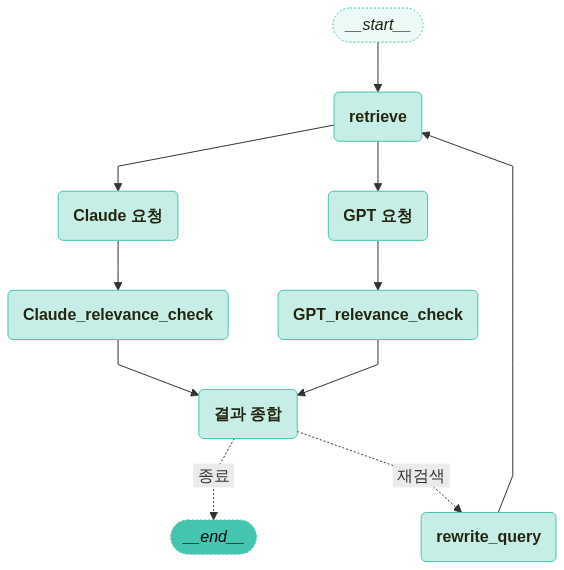

In [6]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

# (1): Conventional RAG
# (2): 재검색
# (3): 멀티 LLM
# (4): 쿼리 재작성


# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가합니다.
workflow.add_node("retrieve", retrieve)

workflow.add_node("rewrite_query", rewrite_query)  # (4)

workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("Claude 요청", llm_claude_execute)  # (3)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Claude_relevance_check", relevance_check)  # (3)
workflow.add_node("결과 종합", sum_up)

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "GPT 요청")
workflow.add_edge("retrieve", "Claude 요청")  # (3)
workflow.add_edge("rewrite_query", "retrieve")  # (4)
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")
workflow.add_edge("Claude 요청", "Claude_relevance_check")  # (3)
workflow.add_edge("Claude_relevance_check", "결과 종합")  # (3)

# workflow.add_edge("결과 종합", END)  # (2) - off

# 조건부 엣지를 추가합니다. (2), (4)
# workflow.add_conditional_edges(
#     "결과 종합",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
#     decision,
#     {
#         "재검색": "retrieve",  # 관련성이 있으면 종료합니다.
#         "종료": END,  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
#     },
# )

# 조건부 엣지를 추가합니다. (4)
workflow.add_conditional_edges(
    "결과 종합",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    decision,
    {
        "재검색": "rewrite_query",  # 관련성이 있으면 종료합니다.
        "종료": END,  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

# 시작점을 설정합니다.
workflow.set_entry_point("retrieve")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(app)


In [7]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가합니다.
workflow.add_node("질문", retrieve)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("rewrite_question", rewrite_query)
workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)
workflow.add_node("get_table_info", get_table_info)
workflow.add_node("generate_sql_query", generate_sql_query)
workflow.add_node("execute_sql_query", execute_sql_query)
workflow.add_node("validate_sql_query", validate_sql_query)

# 각 노드들을 연결합니다.
workflow.add_edge("질문", "get_table_info")
workflow.add_edge("get_table_info", "generate_sql_query")
workflow.add_edge("generate_sql_query", "execute_sql_query")
workflow.add_edge("execute_sql_query", "validate_sql_query")

workflow.add_conditional_edges(
    "validate_sql_query",
    decision,
    {
        "QUERY ERROR": "rewrite_query",
        "UNKNOWN MEANING": "rewrite_question",
        "PASS": "GPT 요청",
    },
)

workflow.add_edge("rewrite_query", "execute_sql_query")
workflow.add_edge("rewrite_question", "rewrite_query")
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")
workflow.add_edge("결과 종합", END)

# 시작점을 설정합니다.
workflow.set_entry_point("질문")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)


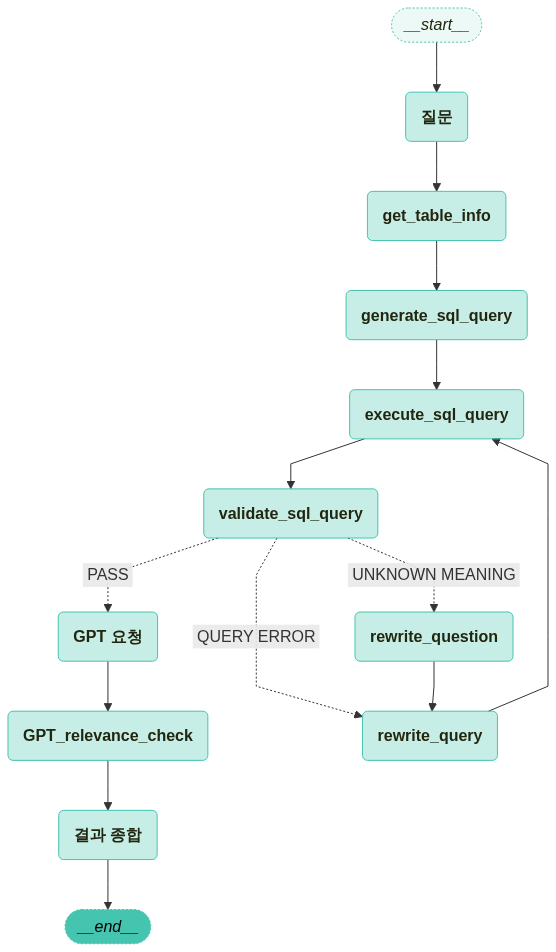

In [8]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


02. Naive RAG

In [14]:
!pip install -q faiss-cpu

In [15]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


In [16]:
search_result = pdf_retriever.invoke("앤스로픽에 투자한 기업과 투자금액을 알려주세요.")
search_result


[Document(id='97c8bdbc-1b33-4a96-9f48-7fe9e612160a', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 13, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육\n구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화\nKEY Contents\nn 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은\n구글과 클라우드 서비스 사용 계약도 체결\nn 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인\n앤스로픽 및 오픈AI와 협력을 확대하는 추세\n£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공'),
 Document(id='d2778644-a7af-4f6a-9921-e96efec3899f', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 13, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+0

In [17]:
# 검색 결과를 기반으로 답변을 생성합니다.
answer = pdf_chain.invoke(
    {
        "question": "앤스로픽에 투자한 기업과 투자금액을 알려주세요.",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)


구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 또한, 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 공개했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)


In [18]:
# 검색 결과를 기반으로 답변을 생성합니다.
answer = pdf_chain.invoke(
    {
        "question": "앤스로픽에 투자한 기업과 투자금액을 알려주세요.",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)


구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 또한, 구글은 2023년 2월에 이미 5억 5,000만 달러를 앤스로픽에 투자한 바 있습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)


In [19]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)


In [20]:
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


In [21]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)


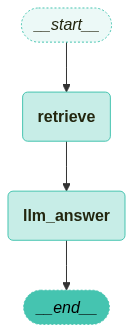

In [22]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


In [23]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="앤스로픽에 투자한 기업과 투자금액을 알려주세요.")

# 그래프 실행
stream_graph(app, inputs, config, ["llm_answer"])



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)

In [24]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')


Question: 앤스로픽에 투자한 기업과 투자금액을 알려주세요.
Answer:
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)


03. 관련성 체커(Relevance Checker) 모듈 추가

In [25]:
from rag.pdf import PDFRetrievalChain  

# PDF 문서를 로드합니다.  
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()  

# retriever와 chain을 생성합니다.  
pdf_retriever = pdf.retriever  
pdf_chain = pdf.chain  


In [26]:
from typing import Annotated, TypedDict  
from langgraph.graph.message import add_messages  


# GraphState 상태 정의  
class GraphState(TypedDict):  
    question: Annotated[str, "Question"]  # 질문  
    context: Annotated[str, "Context"]  # 문서의 검색 결과  
    answer: Annotated[str, "Answer"]  # 답변  
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)  
    relevance: Annotated[str, "Relevance"]  # 관련성  


In [27]:
from langchain_openai import ChatOpenAI  
from langchain_teddynote.evaluator import GroundednessChecker  
from langchain_teddynote.messages import messages_to_history  
from rag.utils import format_docs  


# 문서 검색 노드  
def retrieve_document(state: GraphState) -> GraphState:  
    # 질문을 상태에서 가져옵니다.  
    latest_question = state["question"]  

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.  
    retrieved_docs = pdf_retriever.invoke(latest_question)  

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)  
    retrieved_docs = format_docs(retrieved_docs)  

    # 검색된 문서를 context 키에 저장합니다.  
    return GraphState(context=retrieved_docs)  


# 답변 생성 노드  
def llm_answer(state: GraphState) -> GraphState:  
    # 질문을 상태에서 가져옵니다.  
    latest_question = state["question"]  

    # 검색된 문서를 상태에서 가져옵니다.  
    context = state["context"]  

    # 체인을 호출하여 답변을 생성합니다.  
    response = pdf_chain.invoke(  
        {  
            "question": latest_question,  
            "context": context,  
            "chat_history": messages_to_history(state["messages"]),  
        }  
    )  

    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.  
    return GraphState(  
        answer=response, messages=[("user", latest_question), ("assistant", response)]  
    )  


# 관련성 체크 노드  
def relevance_check(state: GraphState) -> GraphState:  
    # 관련성 평가기를 생성합니다.  
    question_answer_relevant = GroundednessChecker(  
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"  
    ).create()  

    # 관련성 체크를 실행("yes" or "no")  
    response = question_answer_relevant.invoke(  
        {"question": state["question"], "context": state["context"]}  
    )  

    print("==== [RELEVANCE CHECK] ====")  
    print(response.score)  

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!  
    return GraphState(relevance=response.score)  


# 관련성 체크하는 함수(router)  
def is_relevant(state: GraphState) -> GraphState:  
    return state["relevance"]  


In [28]:
from langgraph.graph import END, StateGraph  
from langgraph.checkpoint.memory import MemorySaver  

# 그래프 정의  
workflow = StateGraph(GraphState)  

# 노드 추가  
workflow.add_node("retrieve", retrieve_document)  
# 관련성 체크 노드 추가  
workflow.add_node("relevance_check", relevance_check)  
workflow.add_node("llm_answer", llm_answer)  

# 엣지 추가  
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크  


# # 조건부 엣지를 추가합니다.  
workflow.add_conditional_edges(  
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.  
    is_relevant,  
    {  
        "yes": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.  
        "no": "retrieve",  # 관련성이 없으면 다시 검색합니다.  
    },  
)  

# 그래프 진입점 설정  
workflow.set_entry_point("retrieve")  

# 체크포인터 설정  
memory = MemorySaver()  

# 그래프 컴파일  
app = workflow.compile(checkpointer=memory)  


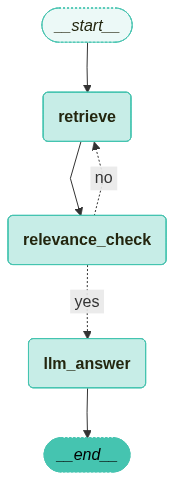

In [29]:
from langchain_teddynote.graphs import visualize_graph  

visualize_graph(app)  


In [30]:
from langchain_core.runnables import RunnableConfig  
from langchain_teddynote.messages import stream_graph, random_uuid  

# config 설정(재귀 최대 횟수, thread_id)  
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})  

# 질문 입력  
inputs = GraphState(question="앤스로픽에 투자한 기업과 투자금액을 알려주세요.")  

# 그래프 실행  
stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])  



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"yes==== [RELEVANCE CHECK] ====
yes
"}
🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)

In [31]:
outputs = app.get_state(config).values  

print(f'Question: {outputs["question"]}')  
print("===" * 20)  
print(f'Answer:\n{outputs["answer"]}')  


Question: 앤스로픽에 투자한 기업과 투자금액을 알려주세요.
Answer:
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)


In [33]:
print(outputs["relevance"])  


yes


In [34]:
from langgraph.errors import GraphRecursionError  
from langchain_core.runnables import RunnableConfig  

# config 설정(재귀 최대 횟수, thread_id)  
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})  

# 질문 입력  
inputs = GraphState(question="테디노트의 랭체인 튜토리얼에 대한 정보를 알려주세요.")  

try:  
    # 그래프 실행  
    stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])  
except GraphRecursionError as recursion_error:  
    print(f"GraphRecursionError: {recursion_error}")  



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no
GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


04. 웹 검색 모듈 추가

In [35]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


In [36]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]  # 관련성


In [37]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = question_answer_relevant.invoke(
        {"question": state["question"], "context": state["context"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return GraphState(relevance=response.score)


# 관련성 체크하는 함수(router)
def is_relevant(state: GraphState) -> GraphState:
    return state["relevance"]


In [38]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tavily_tool = TavilySearch()

search_query = "실시간 미국 대선 투표 결과는?"

# 다양한 파라미터를 사용한 검색 예제
search_result = tavily_tool.search(
    query=search_query,  # 검색 쿼리
    topic="news",  # 일반 주제
    days=1,  # 최근 1일 내 검색
    max_results=3,  # 최대 검색 결과
    format_output=True,  # 결과 포맷팅
)

print("\n".join(search_result))


<document><title>Democrats Flip Key Seat In Iowa District That Trump Won By Double Digits - HuffPost</title><url>https://www.huffpost.com/entry/catelin-drey-iowa-win_n_68ae850ee4b0ba4856d3cc50</url><content># Democrats Flip Key Seat In Iowa District That Trump Won By Double Digits Democrats flipped a state Senate seat in an Iowa district that President Donald Trump won by 11 points in 2024 in a victory that also breaks a Republican supermajority in the chamber. The previous election, in February, saw Democrats flip a seat in a district Trump had won by 21 points. Jeez, Even Trump Is Weighing In On The New Cracker Barrel Logo Trump Fires Fed Governor Lisa Cook, Opening New Front In Fight For Control Over Central Bank 'Get Noted, Donald': Dem Governor Hits Trump With Blistering Real-Time Fact Check CNN Data Chief Flags This Major Way That Newsom's Trump Trolling Is 'Working'</content><raw>[Skip to Main Content](#main)

WE'RE NOT

Protect the free press

[Support HuffPost](https://www.huf

In [39]:
# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    # 검색 도구 생성
    tavily_tool = TavilySearch()

    search_query = state["question"]

    # 다양한 파라미터를 사용한 검색 예제
    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="news",  # 일반 주제
        days=1,
        max_results=3,  # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return GraphState(context="\n".join(search_result))


In [40]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# Web Search 노드 추가
workflow.add_node("web_search", web_search)

# 엣지 추가
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크


# # 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "yes": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.
        "no": "web_search",  # 관련성이 없으면 다시 검색합니다.
    },
)

workflow.add_edge("web_search", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)


In [41]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="도널드 트럼프 대통령")

# 그래프 실행
stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"no"}==== [RELEVANCE CHECK] ====
no

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
도널드 트럼프 대통령은 2024년 대선 이후 15억 달러 이상을 모금했다고 발표했습니다. 그는 "위대한 대통령 선거 이후 다양한 형태와 정치 단체를 통해 15억 달러 이상을 모금했다"고 Truth Social 플랫폼에서 밝혔습니다. 이 발표는 미국 경제에 대한 심각한 우려 속에서 이루어졌습니다.

**Source**
- HuffPost (page 1)
- CNN (page 1)
- AP News (page 1)

In [42]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')


Question: 도널드 트럼프 대통령
Answer:
도널드 트럼프 대통령은 2024년 대선 이후 15억 달러 이상을 모금했다고 발표했습니다. 그는 "위대한 대통령 선거 이후 다양한 형태와 정치 단체를 통해 15억 달러 이상을 모금했다"고 Truth Social 플랫폼에서 밝혔습니다. 이 발표는 미국 경제에 대한 심각한 우려 속에서 이루어졌습니다.

**Source**
- HuffPost (page 1)
- CNN (page 1)
- AP News (page 1)


05. 쿼리 재작성 모듈 추가

In [43]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


In [44]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[list, add_messages]  # 질문(누적되는 list)
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]  # 관련성


In [45]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = question_answer_relevant.invoke(
        {"question": state["question"][-1].content, "context": state["context"]}
    )

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return GraphState(relevance=response.score)


# 관련성 체크하는 함수(router)
def is_relevant(state: GraphState) -> GraphState:
    return state["relevance"]


# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    # 검색 도구 생성
    tavily_tool = TavilySearch()

    search_query = state["question"][-1].content

    # 다양한 파라미터를 사용한 검색 예제
    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="general",  # 일반 주제
        max_results=3,  # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return GraphState(context="\n".join(search_result))


In [46]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Query Rewrite 프롬프트 정의
re_write_prompt = PromptTemplate(
    template="""Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

- Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
- Consider the context and potential keywords that would optimize retrieval.
- Maintain the intent of the original question while enhancing its structure and vocabulary.

# Steps

1. **Understand the Original Question**: Identify the core intent and any keywords.
2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.

# Output Format

- Provide a single, improved question.
- Do not include any introductory or explanatory text; only the reformulated question.

# Examples

**Input**: 
"What are the benefits of using renewable energy sources over fossil fuels?"

**Output**: 
"How do renewable energy sources compare to fossil fuels in terms of benefits?"

**Input**: 
"How does climate change impact polar bear populations?"

**Output**: 
"What effects does climate change have on polar bear populations?"

# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
    input_variables=["generation", "question"],
)

question_rewriter = (
    re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
)


In [47]:
# 질문 재작성
question = "앤스로픽에 투자한 미국기업"

question_rewriter.invoke({"question": question})


'앤스로픽에 투자한 미국 기업은 어떤 곳들이 있나요?'

In [48]:
# Query Rewrite 노드
def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    return GraphState(question=question_rewritten)


In [49]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("web_search", web_search)

# Query Rewrite 노드 추가
workflow.add_node("query_rewrite", query_rewrite)

# 엣지 추가
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크
# workflow.add_edge("relevance_check", "llm_answer")  # 관련성 체크 -> 답변
workflow.add_edge("query_rewrite", "retrieve")  # 질문 재작성 -> 검색

# # 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "yes": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.
        "no": "web_search",  # 관련성이 없으면 다시 검색합니다.
    },
)

workflow.add_edge("web_search", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("query_rewrite")

# 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)


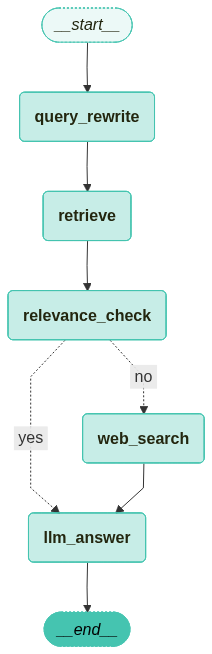

In [50]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


In [51]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="앤스로픽 투자 금액")

# 그래프 실행
stream_graph(app, inputs, config, ["query_rewrite", "llm_answer"])



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
앤스로픽에 대한 투자 금액은 얼마인가요?
🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 계획입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)

In [52]:
outputs = app.get_state(config).values

print(f'Original Question: {outputs["question"][0].content}')
print(f'Rewritten Question: {outputs["question"][-1].content}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')


Original Question: 앤스로픽 투자 금액
Rewritten Question: 앤스로픽에 대한 투자 금액은 얼마인가요?
Answer:
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 계획입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)


06. Agentic RAG

In [53]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


In [54]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# PDF 문서를 기반으로 검색 도구 생성
retriever_tool = create_retriever_tool(
    pdf_retriever,
    "pdf_retriever",
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

# 생성된 검색 도구를 도구 리스트에 추가하여 에이전트에서 사용 가능하도록 설정
tools = [retriever_tool]


In [55]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


# 에이전트 상태를 정의하는 타입 딕셔너리, 메시지 시퀀스를 관리하고 추가 동작 정의
class AgentState(TypedDict):
    # add_messages reducer 함수를 사용하여 메시지 시퀀스를 관리
    messages: Annotated[Sequence[BaseMessage], add_messages]


In [56]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langchain_teddynote.models import get_model_name, LLMs

# 최신 모델이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4)


# 데이터 모델 정의
class grade(BaseModel):
    """A binary score for relevance checks"""

    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )


def grade_documents(state) -> Literal["generate", "rewrite"]:
    # LLM 모델 초기화
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)

    # 구조화된 출력을 위한 LLM 설정
    llm_with_tool = model.with_structured_output(grade)

    # 프롬프트 템플릿 정의
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # llm + tool 바인딩 체인 생성
    chain = prompt | llm_with_tool

    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # 가장 마지막 메시지 추출
    last_message = messages[-1]

    # 원래 질문 추출
    question = messages[0].content

    # 검색된 문서 추출
    retrieved_docs = last_message.content

    # 관련성 평가 실행
    scored_result = chain.invoke({"question": question, "context": retrieved_docs})

    # 관련성 여부 추출
    score = scored_result.binary_score

    # 관련성 여부에 따른 결정
    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        return "generate"

    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        print(score)
        return "rewrite"


def agent(state):
    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # LLM 모델 초기화
    model = ChatOpenAI(temperature=0, streaming=True, model=MODEL_NAME)

    # retriever tool 바인딩
    model = model.bind_tools(tools)

    # 에이전트 응답 생성
    response = model.invoke(messages)

    # 기존 리스트에 추가되므로 리스트 형태로 반환
    return {"messages": [response]}


def rewrite(state):
    print("==== [QUERY REWRITE] ====")
    # 현재 상태에서 메시지 추출
    messages = state["messages"]
    # 원래 질문 추출
    question = messages[0].content

    # 질문 개선을 위한 프롬프트 구성
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # LLM 모델로 질문 개선
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    # Query-Transform 체인 실행
    response = model.invoke(msg)

    # 재작성된 질문 반환
    return {"messages": [response]}


def generate(state):
    # 현재 상태에서 메시지 추출
    messages = state["messages"]

    # 원래 질문 추출
    question = messages[0].content

    # 가장 마지막 메시지 추출
    docs = messages[-1].content

    # RAG 프롬프트 템플릿 가져오기
    prompt = hub.pull("teddynote/rag-prompt")

    # LLM 모델 초기화
    llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0, streaming=True)

    # RAG 체인 구성
    rag_chain = prompt | llm | StrOutputParser()

    # 답변 생성 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


In [57]:
# LangGraph 라이브러리의 그래프 및 도구 노드 컴포넌트 임포트
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# AgentState 기반 상태 그래프 워크플로우 초기화
workflow = StateGraph(AgentState)

# 워크플로우 내 순환 노드 정의 및 추가
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node("generate", generate)  # 관련 문서 확인 후 응답 생성 노드

# 시작점에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 검색 여부 결정을 위한 조건부 엣지 추가
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 노드에 매핑
        "tools": "retrieve",
        END: END,
    },
)

# 액션 노드 실행 후 처리될 엣지 정의
workflow.add_conditional_edges(
    "retrieve",
    # 문서 품질 평가
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 워크플로우 그래프 컴파일
graph = workflow.compile()


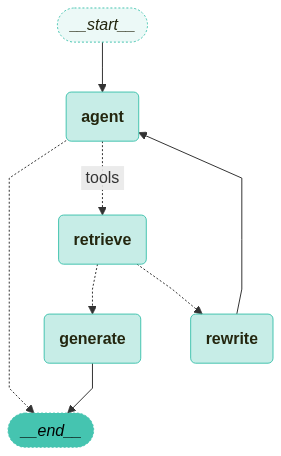

In [58]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)


In [59]:
from langchain_teddynote.messages import stream_graph
from langchain_core.runnables import RunnableConfig

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1"})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

# 그래프 실행
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])



🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [DECISION: DOCS RELEVANT] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)

In [60]:
# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "대한민국의 수도는?"),
    ]
}

# 그래프 실행
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])



🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
대한민국의 수도는 서울특별시입니다.

In [61]:
from langgraph.errors import GraphRecursionError

# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "테디노트의 LangChain 튜토리얼 주소는?"),
    ]
}

try:
    # 그래프 실행
    stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")



🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
테디노트의 LangChain 튜토리얼 주소는 [여기](https://teddynote.me/categories/langchain/)에서 확인하실 수 있습니다.

07. Adaptive RAG

In [62]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever 생성
pdf_retriever = pdf.retriever

# chain 생성
pdf_chain = pdf.chain


In [63]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# 최신 LLM 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4)


# 사용자 쿼리를 가장 관련성 높은 데이터 소스로 라우팅하는 데이터 모델
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    # 데이터 소스 선택을 위한 리터럴 타입 필드
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# LLM 초기화 및 함수 호출을 통한 구조화된 출력 생성
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# 시스템 메시지와 사용자 질문을 포함한 프롬프트 템플릿 생성
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to DEC 2023 AI Brief Report(SPRI) with Samsung Gause, Anthropic, etc.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# Routing 을 위한 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 라우터를 결합하여 질문 라우터 생성
question_router = route_prompt | structured_llm_router


In [64]:
# 문서 검색이 필요한 질문
print(
    question_router.invoke(
        {"question": "AI Brief 에서 삼성전자가 만든 생성형 AI 의 이름은?"}
    )
)


datasource='vectorstore'


In [65]:
# 웹 검색이 필요한 질문
print(question_router.invoke({"question": "판교에서 가장 맛있는 딤섬집 찾아줘"}))


datasource='web_search'


In [66]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


# 문서 평가를 위한 데이터 모델 정의
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화 및 함수 호출을 통한 구조화된 출력 생성
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 메시지와 사용자 질문을 포함한 프롬프트 템플릿 생성
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 문서 검색결과 평가기 생성
retrieval_grader = grade_prompt | structured_llm_grader


In [67]:
# 사용자 질문 설정
question = "삼성전자가 만든 생성형 AI 의 이름은?"

# 질문에 대한 관련 문서 검색
docs = pdf_retriever.invoke(question)

# 검색된 문서의 내용 가져오기
retrieved_doc = docs[1].page_content

# 평가 결과 출력
print(retrieval_grader.invoke({"question": question, "document": retrieved_doc}))


binary_score='yes'


In [68]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LangChain Hub에서 프롬프트 가져오기(RAG 프롬프트는 자유롭게 수정 가능)
prompt = hub.pull("teddynote/rag-prompt")

# LLM 초기화
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)


# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# RAG 체인 생성
rag_chain = prompt | llm | StrOutputParser()


In [69]:
# RAG 체인에 질문을 전달하여 답변 생성
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)


삼성전자가 만든 생성형 AI의 이름은 '삼성 가우스'입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (페이지 13)


In [70]:
# 할루시네이션 체크를 위한 데이터 모델 정의
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# 함수 호출을 통한 LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# 프롬프트 설정
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 프롬프트 템플릿 생성
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# 환각 평가기 생성
hallucination_grader = hallucination_prompt | structured_llm_grader


In [71]:
# 평가기를 사용하여 생성된 답변의 환각 여부 평가
hallucination_grader.invoke({"documents": docs, "generation": generation})


GradeHallucinations(binary_score='yes')

In [72]:
class GradeAnswer(BaseModel):
    """Binary scoring to evaluate the appropriateness of answers to questions"""

    binary_score: str = Field(
        description="Indicate 'yes' or 'no' whether the answer solves the question"
    )


# 함수 호출을 통한 LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# 프롬프트 설정
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 평가기를 결합하여 답변 평가기 생성
answer_grader = answer_prompt | structured_llm_grader


In [73]:
# 평가기를 사용하여 생성된 답변이 질문을 해결하는지 여부 평가
answer_grader.invoke({"question": question, "generation": generation})


GradeAnswer(binary_score='yes')

In [74]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Query Rewriter 프롬프트 정의(자유롭게 수정이 가능합니다)
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

# Query Rewriter 프롬프트 템플릿 생성
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Query Rewriter 생성
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [75]:
# 질문 재작성기에 질문을 전달하여 개선된 질문 생성
question_rewriter.invoke({"question": question})


'삼성전자가 개발한 생성형 인공지능의 이름은 무엇인가요?'

In [76]:
from langchain_teddynote.tools.tavily import TavilySearch

# 웹 검색 도구 생성
web_search_tool = TavilySearch(max_results=3)


In [77]:
# 웹 검색 도구 호출
result = web_search_tool.search("테디노트 위키독스 랭체인 튜토리얼 URL 을 알려주세요")
print(result)


[{'url': 'https://www.youtube.com/watch?v=mVu6Wj8Z7C0', 'title': '랭체인 한국어 튜토리얼     업데이트 소식   처음 사용자를 위한 친절한 ...', 'content': '#랭체인 한국어 튜토리얼🇰🇷 업데이트 소식🔥 처음 사용자를 위한 친절한 환경설치(Windows, Mac)\n\n테디노트 TeddyNote\n317 likes\n16451 views\n19 Jun 2024\n📝 환경설정(Windows)\nhttps://teddynote.com/10-RAG%EB%B9%84%EB%B2%95%EB%85%B8%ED%8A%B8/%ED%99%98%EA%B2%BD%20%EC%84%A4%EC%A0%95%20(Windows)/\n\n📝 환경설정(Mac)\nhttps://teddynote.com/10-RAG%EB%B9%84%EB%B2%95%EB%85%B8%ED%8A%B8/%ED%99%98%EA%B2%BD%20%EC%84%A4%EC%A0%95%20(Mac)/\n\n📍[패스트캠퍼스] "테디노트의 RAG 비법노트" 강의\n링크: https://bit.ly/4e1h8zO\n\n🤖 디스코드 채널\nhttps://discord.gg/q3RvQZ5CfK\n\n📘 랭체인 튜토리얼 무료 전자책(wikidocs)\nhttps://wikidocs.net/book/14314\n\n✅ 랭체인 한국어 튜토리얼 코드저장소(GitHub)\nhttps://github.com/teddylee777/langchain-kr\n\n✅ 줄거리\n00:00 랭체인 한국어 튜토리얼 공지사항\n01:59 langchain-teddynote 패키지\n08:25 감사인사\n09:15 Windows 환경설치\n21:48 Mac 환경설치\n\n#rag #langchain\n---\n📍 "테디노트의 RAG 비법노트" 랭체인 강의: https://fastcampus.co.kr/data_online_teddy\n📘 랭체인 한국어 튜토리얼(무료 전자책): https://wikidoc

In [78]:
from typing import List
from typing_extensions import TypedDict, Annotated


# 그래프의 상태 정의
class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 데이터 모델

    Attributes:
        question: 질문
        generation: LLM 생성된 답변
        documents: 도큐먼틑 리스트
    """

    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]


In [79]:
from langchain_core.documents import Document


# 문서 검색 노드
def retrieve(state):
    print("==== [RETRIEVE] ====")
    question = state["question"]

    # 문서 검색 수행
    documents = pdf_retriever.invoke(question)
    return {"documents": documents, "question": question}


# 답변 생성 노드
def generate(state):
    print("==== [GENERATE] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # RAG 답변 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


# 문서 관련성 평가 노드
def grade_documents(state):
    print("==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # 각 문서에 대한 관련성 점수 계산
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            # 관련성이 있는 문서 추가
            filtered_docs.append(d)
        else:
            # 관련성이 없는 문서는 건너뛰기
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


# 질문 재작성 노드
def transform_query(state):
    print("==== [TRANSFORM QUERY] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


# 웹 검색 노드
def web_search(state):
    print("==== [WEB SEARCH] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]

    # 웹 검색 수행
    web_results = web_search_tool.invoke({"query": question})
    web_results_docs = [
        Document(
            page_content=web_result["content"],
            metadata={"source": web_result["url"]},
        )
        for web_result in web_results
    ]

    return {"documents": web_results_docs, "question": question}


In [80]:
# 질문 라우팅 노드
def route_question(state):
    print("==== [ROUTE QUESTION] ====")
    # 질문 가져오기
    question = state["question"]
    # 질문 라우팅
    source = question_router.invoke({"question": question})
    # 질문 라우팅 결과에 따른 노드 라우팅
    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        return "vectorstore"


# 문서 관련성 평가 노드
def decide_to_generate(state):
    print("==== [DECISION TO GENERATE] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 관련성 없는 경우 질문 재작성
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # 관련성 있는 문서가 있는 경우 답변 생성
        print("==== [DECISION: GENERATE] ====")
        return "generate"


def hallucination_check(state):
    print("==== [CHECK HALLUCINATIONS] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # 환각 평가
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Hallucination 여부 확인
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")

        # 답변의 관련성(Relevance) 평가
        print("==== [GRADE GENERATED ANSWER vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score

        # 관련성 평가 결과에 따른 처리
        if grade == "yes":
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"


In [81]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("web_search", web_search)  # 웹 검색
workflow.add_node("retrieve", retrieve)  # 문서 검색
workflow.add_node("grade_documents", grade_documents)  # 문서 평가
workflow.add_node("generate", generate)  # 답변 생성
workflow.add_node("transform_query", transform_query)  # 쿼리 변환

# 그래프 빌드
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",  # 웹 검색으로 라우팅
        "vectorstore": "retrieve",  # 벡터스토어로 라우팅
    },
)
workflow.add_edge("web_search", "generate")  # 웹 검색 후 답변 생성
workflow.add_edge("retrieve", "grade_documents")  # 문서 검색 후 평가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",  # 쿼리 변환 필요
        "generate": "generate",  # 답변 생성 가능
    },
)
workflow.add_edge("transform_query", "retrieve")  # 쿼리 변환 후 문서 검색
workflow.add_conditional_edges(
    "generate",
    hallucination_check,
    {
        "hallucination": "generate",  # Hallucination 발생 시 재생성
        "relevant": END,  # 답변의 관련성 여부 통과
        "not relevant": "transform_query",  # 답변의 관련성 여부 통과 실패 시 쿼리 변환
    },
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())


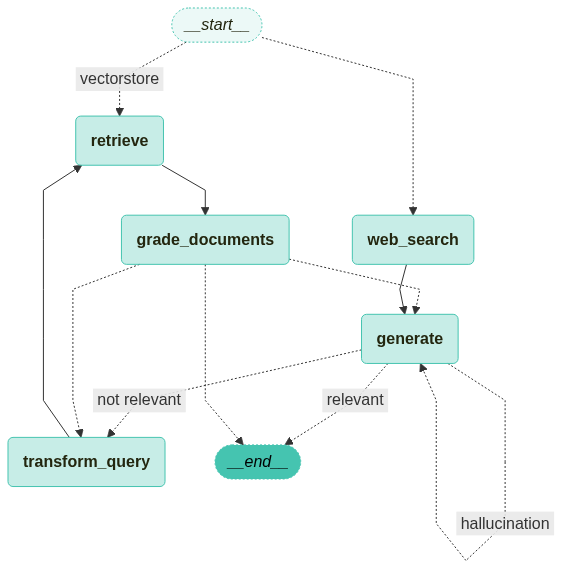

In [82]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


In [83]:
from langchain_teddynote.messages import stream_graph
from langchain_core.runnables import RunnableConfig
import uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": uuid.uuid4()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

# 그래프 실행
stream_graph(app, inputs, config, ["agent", "rewrite", "generate"])


==== [ROUTE QUESTION] ====
==== [ROUTE QUESTION TO VECTORSTORE] ====
==== [RETRIEVE] ====
==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
==== [DECISION TO GENERATE] ====
==== [DECISION: GENERATE] ====
==== [GENERATE] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
삼성전자가 개발한 생성형 AI의 이름은 '삼성 가우스'입니다.

**Source**
- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)==== [CHECK HALLUCINATIONS] ====
{"binary_score":"yes"}==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====
==== [GRADE GENERATED ANSWER vs QUESTION] ====
{"binary_score":"yes"}==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====


In [84]:
# 질문 입력
inputs = {
    "question": "2024년 노벨 문학상 수상자는 누구인가요?",
}

# 그래프 실행
stream_graph(app, inputs, config, ["agent", "rewrite", "generate"])


==== [ROUTE QUESTION] ====
==== [ROUTE QUESTION TO WEB SEARCH] ====
==== [WEB SEARCH] ====
==== [GENERATE] ====

🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 노벨 문학상 수상자는 한국 소설가 한강입니다.

**Source**
- https://www.youtube.com/watch?v=CW2QkiLd_8I
- https://moonji.com/38049/
- https://blog.naver.com/hitecs/223616059397==== [CHECK HALLUCINATIONS] ====
{"binary_score":"yes"}==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====
==== [GRADE GENERATED ANSWER vs QUESTION] ====
{"binary_score":"no"}==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====
==== [TRANSFORM QUERY] ====
==== [RETRIEVE] ====
==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT

GraphRecursionError: Recursion limit of 20 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT